# Comparison of Mission Arrays with 4.5 m AWAC

In [1]:
import cftime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
mission_list = glob.glob('../microSWIFT_data/final_dataset/mission_*.nc')
bathy_file = '../microSWIFT_data/FRFdata/' \
             'FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'
array_8m_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_8m-array_202110.nc'
awac_6m_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-6m_202110.nc'

In [3]:
microSWIFT_sig_wave_heights = []
mission_times = []
standard_deviations = []
awac_sig_wave_heights = []
num_waves_in_mission = []
mean_wave_periods  = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                          y_locations,
                                                          eta, time,
                                                          bathy_file)

    sig_wave_height, \
    standard_dev  = mission_tools.compute_sig_wave_height_top_third(wave_heights)

    microSWIFT_sig_wave_heights.append(sig_wave_height)
    num_waves_in_mission.append(len(wave_heights))
    standard_deviations.append(standard_dev)
    mission_time = np.median(mission_dataset['time'][:])
    mission_times.append(mission_time)

    awac_sig_wave_heights.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_file))

/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Compare the Significant Wave Heights between the microSWIFT arrays and the AWAC

8.135804488911917e-23


(0.0, 4.0)

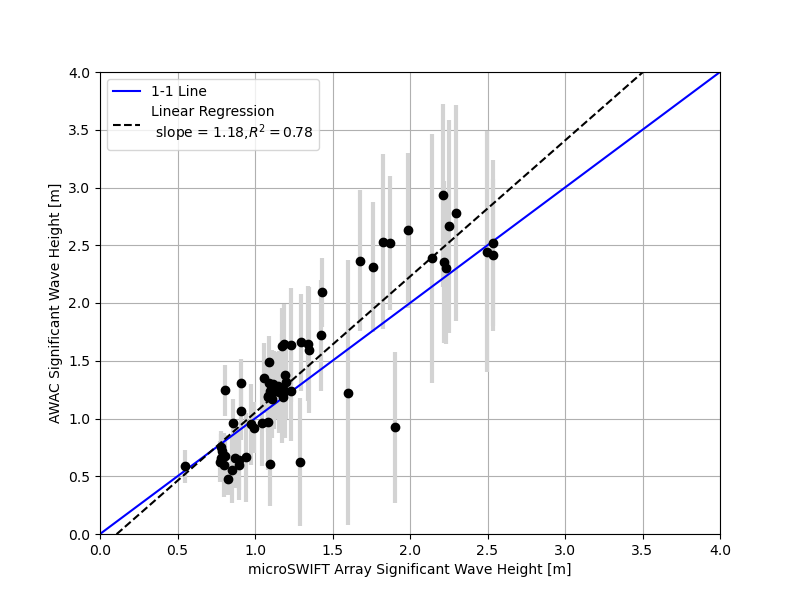

In [4]:
# Compute linear regression between the microSWIFT arrays and the AWAC
slope, \
intercept, \
r_value, \
p_value, \
std_err = stats.linregress(microSWIFT_sig_wave_heights,
                           awac_sig_wave_heights)
print(p_value)
x = np.linspace(0, 4.5)
y = slope * x + intercept

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(microSWIFT_sig_wave_heights, awac_sig_wave_heights,
            yerr=standard_deviations, fmt='o', color='black',
            ecolor='lightgray', elinewidth=3, capsize=0)
ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x, y, color='k', linestyle='dashed', 
        label='Linear Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope, r_value**2))
ax.set_xlabel('microSWIFT Array Significant Wave Height [m]')
ax.set_ylabel('AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

## Compute Residuals between the AWAC and microSWIFT significant wave heights

0.1042157387335444


(array([ 1.,  0.,  1.,  0.,  1.,  2.,  6.,  6.,  9., 14.,  8.,  4.,  8.,
         1.,  6.]),
 array([-0.980353  , -0.86692137, -0.75348974, -0.6400581 , -0.52662647,
        -0.41319484, -0.2997632 , -0.18633157, -0.07289994,  0.0405317 ,
         0.15396333,  0.26739496,  0.3808266 ,  0.49425823,  0.60768986,
         0.7211215 ]),
 <BarContainer object of 15 artists>)

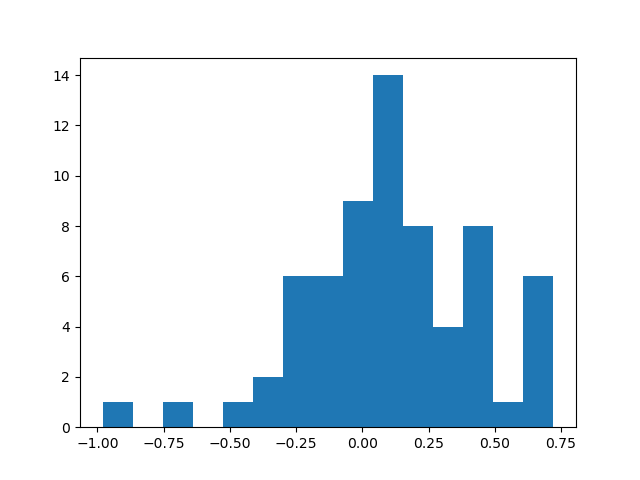

In [5]:
sig_wave_height_residual =  np.array(awac_sig_wave_heights) - np.array(microSWIFT_sig_wave_heights)
mean_residual = np.mean(sig_wave_height_residual)
print(mean_residual)
fig, ax = plt.subplots()
ax.hist(sig_wave_height_residual, bins=15)


## Compare the Significant Wave Heights as a time series

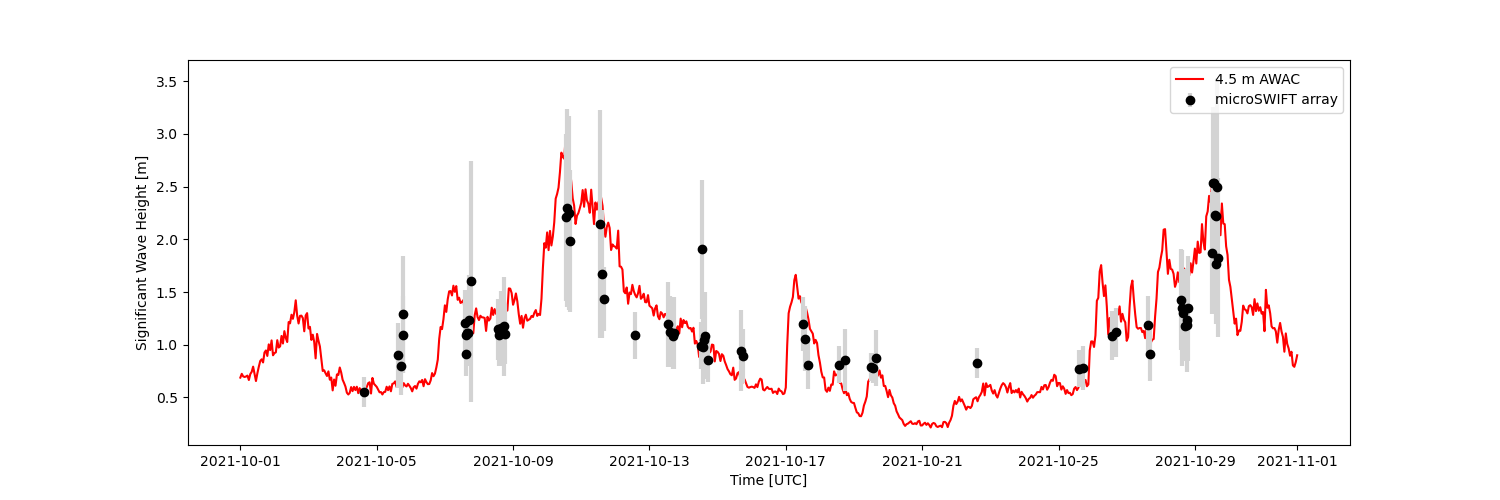

In [6]:
awac_dataset = nc.Dataset(awac_file)
awac_time = cftime.num2pydate(awac_dataset['time'],
                              units=awac_dataset['time'].units,
                              calendar=awac_dataset['time'].calendar)
mission_times_date = cftime.num2pydate(mission_times,
                                       units=mission_dataset['time'].units,
                                       calendar=mission_dataset['time'].calendar)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(awac_time, awac_dataset['waveHs'][:], color='r', label='4.5 m AWAC')
# im = ax.scatter(mission_times_date, microSWIFT_sig_wave_heights,
#            c=num_waves_in_mission, cmap='viridis', label='microSWIFT Arrays')
ax.errorbar(mission_times_date, microSWIFT_sig_wave_heights,
            yerr=standard_deviations, fmt='o', color='black',
            ecolor='lightgray', elinewidth=3, capsize=0, 
            label='microSWIFT array')
ax.set_ylabel('Significant Wave Height [m]')
ax.set_xlabel('Time [UTC]')
ax.legend()
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Number of Individual Waves')


## Compare only waves between 4-5 meters Bathy to the AWAC

In [7]:
microSWIFT_sig_wave_heights_45 = []
mission_times_45 = []
awac_sig_wave_heights_45 = []
num_waves_in_mission_45 = []
standard_deviations_45 = []
wave_heights_each_mission_45 = []
array_8m_sig_wave_heights_45 = []
awac_6m_sig_wave_heights_45 = []
array_8m_Tm_45 = []
awac_6m_Tm_45 = []
average_x_loc_45 = []
average_y_loc_45 = []
array_8m_dir_45 = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file)
    
    wave_bathy = mission_tools.compute_wave_bathy(wave_x_locs,
                                                  wave_y_locs,
                                                  bathy_file)
    wave_heights_45 = []
    wave_periods_45 = []
    wave_x_loc_45 = []
    wave_y_loc_45 = []
    for n in np.arange(len(wave_bathy)):
        if wave_bathy[n] > -5.3 and wave_bathy[n] < -4.3 and ~np.isnan(wave_heights[n]):
            wave_heights_45.append(wave_heights[n])
            wave_x_loc_45.append(wave_x_locs[n])
            wave_y_loc_45.append(wave_y_locs[n])

    if len(wave_heights_45) > 30:
        wave_heights_each_mission_45.append(wave_heights_45)
        significant_wave_height_45, \
        standard_dev_45 = mission_tools.compute_sig_wave_height_top_third(wave_heights_45)
        microSWIFT_sig_wave_heights_45.append(significant_wave_height_45)
        standard_deviations_45.append(standard_dev_45)
        average_x_loc_45.append(np.mean(wave_x_loc_45))
        average_y_loc_45.append(np.mean(wave_y_loc_45))

        mission_time = np.median(mission_dataset['time'][:])
        mission_times_45.append(mission_time)
        num_waves_in_mission_45.append(len(wave_heights_45))
        awac_sig_wave_heights_45.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_file))
        array_8m_sig_wave_heights_45.append(mission_tools.closest_awac_sig_wave_height(mission_time, array_8m_file))
        awac_6m_sig_wave_heights_45.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_6m_file))
        array_8m_Tm_45.append(mission_tools.closest_awac_Tm(mission_time, array_8m_file))
        awac_6m_Tm_45.append(mission_tools.closest_awac_Tm(mission_time, awac_6m_file))
        array_8m_dir_45.append(mission_tools.closest_awac_dir(mission_time, array_8m_file))
    else:
        continue

## Compare the significant wave heights between 4-5 meters

1.5401034714970416e-07


(0.0, 4.5)

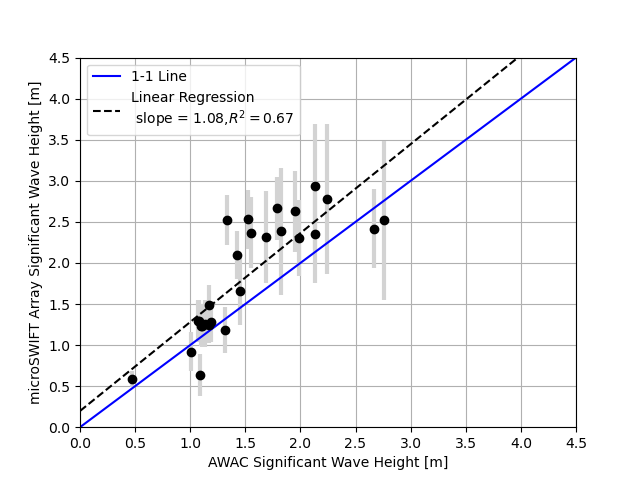

In [8]:
# Compute linear regression between the microSWIFT arrays and the AWAC
slope_45, \
intercept_45, \
r_value_45, \
p_value_45, \
std_err_45 = stats.linregress(microSWIFT_sig_wave_heights_45,
                              awac_sig_wave_heights_45)
print(p_value_45)
x_45 = np.linspace(0, 4.5)
y_45 = slope_45 * x + intercept_45

fig, ax = plt.subplots()
# ax.scatter(microSWIFT_sig_wave_heights_45, awac_sig_wave_heights_45, 
#            c=num_waves_in_mission_45, cmap='viridis')
ax.errorbar(microSWIFT_sig_wave_heights_45, awac_sig_wave_heights_45,
            yerr=standard_deviations_45, fmt='o', color='black',
            ecolor='lightgray', elinewidth=3, capsize=0)

ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x_45, y_45, color='k', linestyle='dashed', 
        label='Linear Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope_45, r_value_45**2))
ax.set_ylabel('microSWIFT Array Significant Wave Height [m]')
ax.set_xlabel('AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)
# ax.axis('equal')
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Number of Individual Waves in Distribution')

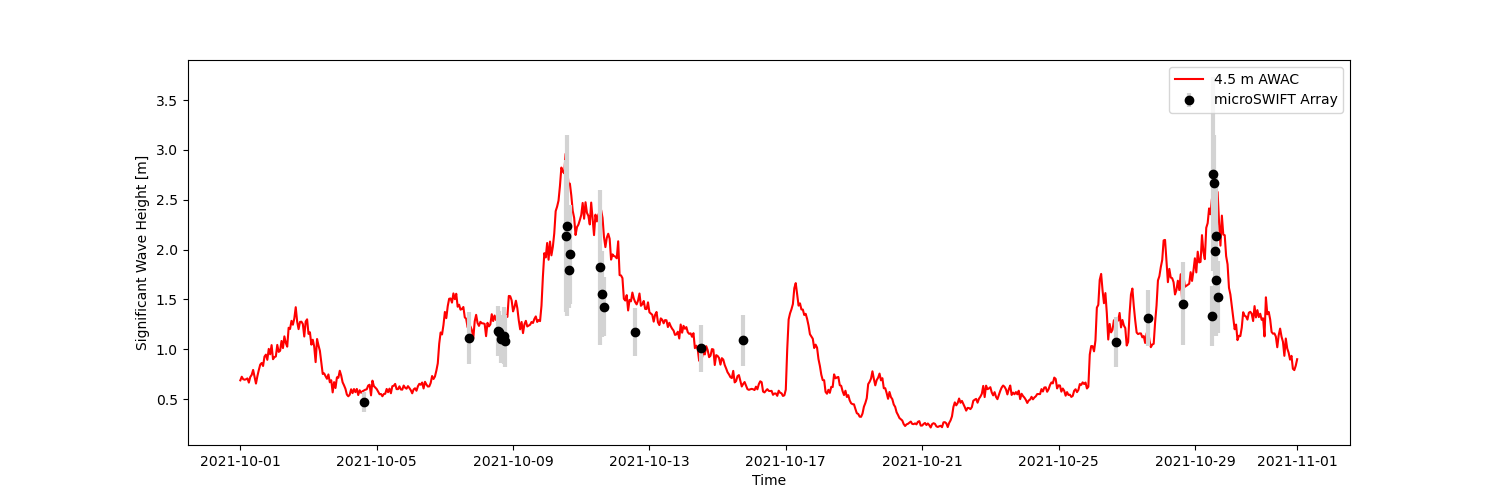

In [9]:
mission_times_date_45 = cftime.num2pydate(mission_times_45,
                                          units=mission_dataset['time'].units,
                                          calendar=mission_dataset['time'].calendar)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(awac_time, awac_dataset['waveHs'][:], color='r', label='4.5 m AWAC')
# ax.scatter(mission_times_date_45, microSWIFT_sig_wave_heights_45,
#            c=num_waves_in_mission_45, cmap='viridis', label='microSWIFT Arrays')
ax.errorbar(mission_times_date_45, microSWIFT_sig_wave_heights_45,
            yerr=standard_deviations_45, fmt='o', color='black',
            ecolor='lightgray', elinewidth=3, capsize=0, label='microSWIFT Array')
# ax2 = ax.twinx()
# ax2.plot(awac_time, awac_dataset['waveMeanDirection'][:], color='b')
# ax2.axhline(71.8)
# ax2.set_ylabel('Mean Wave Direction [degrees]', color='b')
ax.set_ylabel('Significant Wave Height [m]')
ax.set_xlabel('Time')
ax.legend()
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Number of Individual Waves')

-0.325


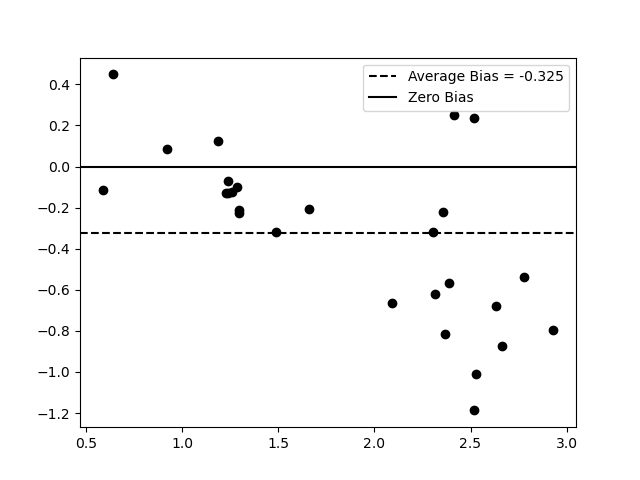

In [10]:
sig_wave_height_bias_45 =  np.array(microSWIFT_sig_wave_heights_45) - np.array(awac_sig_wave_heights_45)
mean_bias_45 = np.round(np.mean(sig_wave_height_bias_45), 3)
print(mean_bias_45)
fig, ax = plt.subplots()
ax.scatter(awac_sig_wave_heights_45, sig_wave_height_bias_45, color='k')
ax.axhline(mean_bias_45, color='k', linestyle='dashed', label=f'Average Bias = {mean_bias_45}')
ax.axhline(0, color='k', label='Zero Bias')
ax.legend()

## Compute the RMS wave height from each mission and Bootstrap to estimate the confidence interval

In [11]:
# Compute the RMS wave height from the first sete of wave heights
ci_for_mission = []
rms_wave_height_for_mission = []

for n in range(len(mission_times_date_45)):
    wave_heights = np.array(wave_heights_each_mission_45[n])
    rms_wave_height = mission_tools.compute_rms_wave_height(wave_heights)
    rms_wave_height_for_mission.append(rms_wave_height)

    # Compute the 95% confidence interval for the RMS wave height using a bootstrap
    wave_heights = (wave_heights,) # data must be in a sequence for the bootstrap function
    bootstrap_ci = stats.bootstrap(wave_heights, mission_tools.compute_rms_wave_height, confidence_level=0.95, method='percentile')
    ci_low = bootstrap_ci.confidence_interval[0]
    ci_high = bootstrap_ci.confidence_interval[1]
    ci_for_mission.append(ci_high - ci_low)

# Convert to numpy arrays
rms_wave_height_for_mission = np.array(rms_wave_height_for_mission)
hs_wave_height_for_mission = rms_wave_height_for_mission * 1.4
ci_for_mission = np.array(ci_for_mission)

In [12]:
print(hs_wave_height_for_mission.size)
print(np.array(microSWIFT_sig_wave_heights_45).size)

27
27


In [13]:
# Compute the root-mean-square-error between the microSWIFT arrays and the 4.5 m AWAC
def rmse(estimate, actual):
    return np.sqrt(np.mean(np.square(estimate - actual)))

rmse_microswifts = rmse(hs_wave_height_for_mission, awac_sig_wave_heights_45)
print(f'The RMSE for the microSWIFT significant wave heights is {np.round(rmse_microswifts, 3)} meters.')

rmse_8marray = rmse(np.array(array_8m_sig_wave_heights_45), awac_sig_wave_heights_45)
print(f'The RMSE for the 8m Array significant wave heights is {np.round(rmse_8marray, 3)} meters.')

rmse_6mawac = rmse(np.array(awac_6m_sig_wave_heights_45), awac_sig_wave_heights_45)
print(f'The RMSE for the 6m AWAC significant wave heights is {np.round(rmse_6mawac, 3)} meters.')

The RMSE for the microSWIFT significant wave heights is 0.52 meters.
The RMSE for the 8m Array significant wave heights is 0.207 meters.
The RMSE for the 6m AWAC significant wave heights is 0.111 meters.


(0.0, 4.5)

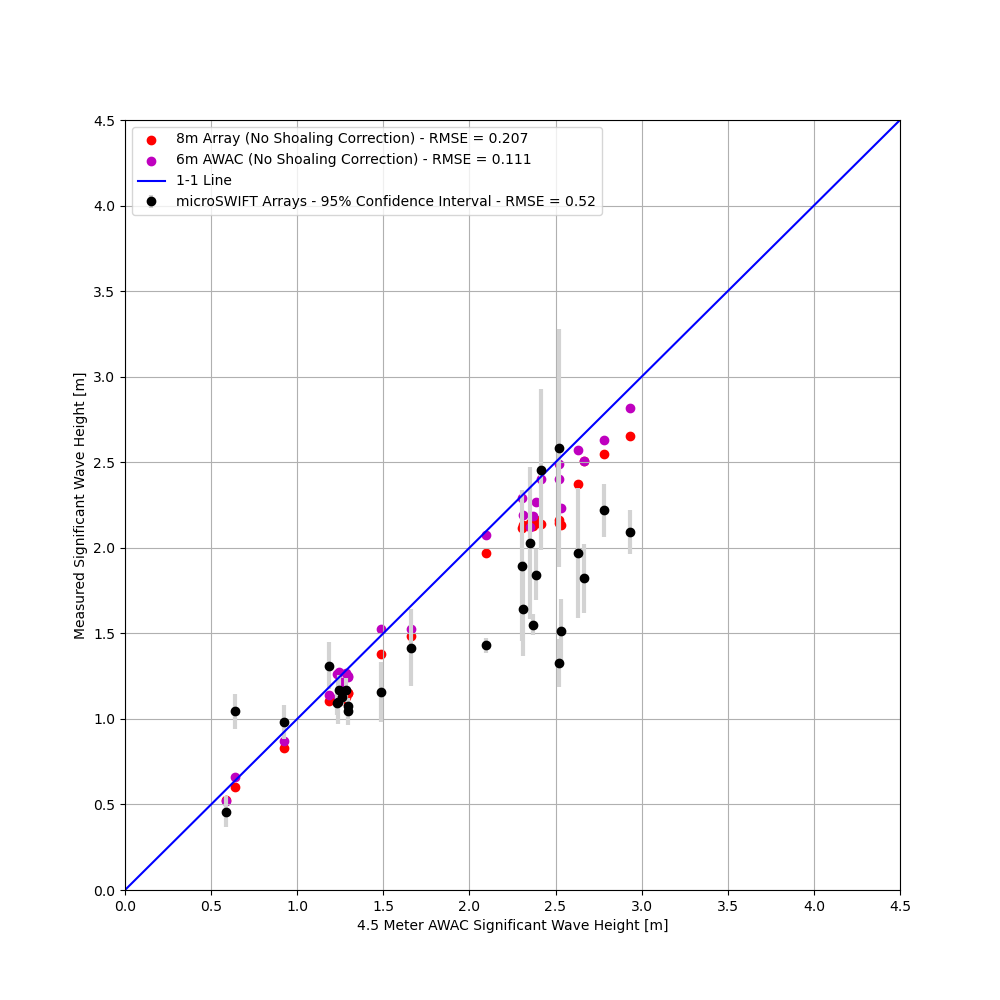

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ax.errorbar(awac_sig_wave_heights_45, hs_wave_height_for_mission,
            yerr=ci_for_mission, fmt='o', color='black',
            ecolor='lightgray', elinewidth=3, capsize=0, label=f'microSWIFT Arrays - 95% Confidence Interval - RMSE = {np.round(rmse_microswifts, 3)}')
ax.scatter(awac_sig_wave_heights_45, array_8m_sig_wave_heights_45, color='r', label=f'8m Array (No Shoaling Correction) - RMSE = {np.round(rmse_8marray, 3)}')
ax.scatter(awac_sig_wave_heights_45, awac_6m_sig_wave_heights_45, color='m', label=f'6m AWAC (No Shoaling Correction) - RMSE = {np.round(rmse_6mawac, 3)}')

ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.set_ylabel('Measured Significant Wave Height [m]')
ax.set_xlabel('4.5 Meter AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)

In [15]:
# Along Shore Distance to Pier for the wave heights
# Pier is at a y location of 505 meters
alongshore_dist_to_pier = np.array([ (505 - y_loc) for y_loc in average_y_loc_45])
# alongshore_dist_to_pier_thresh = alongshore_dist_to_pier[np.abs(alongshore_dist_to_pier) < 30]

(0.0, 4.5)

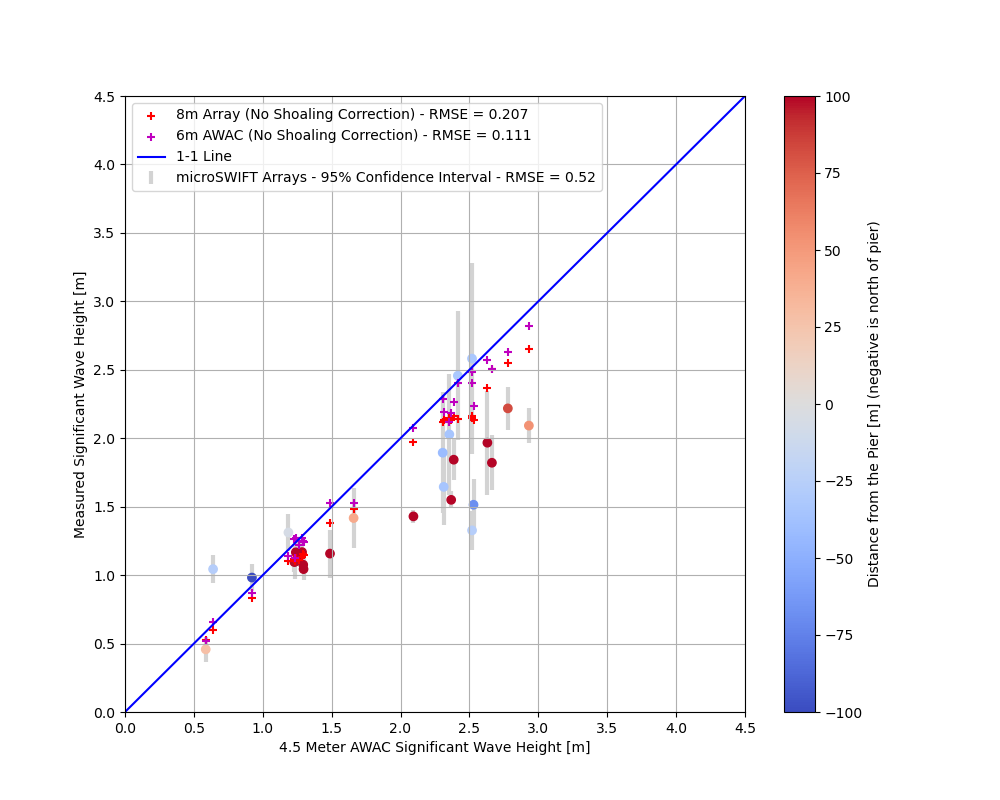

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
ax.errorbar(awac_sig_wave_heights_45, hs_wave_height_for_mission, yerr=ci_for_mission, fmt='none', marker=None,
            ecolor='lightgray', elinewidth=3, capsize=0,
            label=f'microSWIFT Arrays - 95% Confidence Interval - RMSE = {np.round(rmse_microswifts, 3)}',
            zorder=0)
im = ax.scatter(awac_sig_wave_heights_45, hs_wave_height_for_mission, c=alongshore_dist_to_pier, cmap='coolwarm',
                vmin=-100, vmax=100)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Distance from the Pier [m] (negative is north of pier)')
ax.scatter(awac_sig_wave_heights_45, array_8m_sig_wave_heights_45, color='r', marker='+', label=f'8m Array (No Shoaling Correction) - RMSE = {np.round(rmse_8marray, 3)}')
ax.scatter(awac_sig_wave_heights_45, awac_6m_sig_wave_heights_45, color='m', marker='+', label=f'6m AWAC (No Shoaling Correction) - RMSE = {np.round(rmse_6mawac, 3)}')
ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.set_ylabel('Measured Significant Wave Height [m]')
ax.set_xlabel('4.5 Meter AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)



What are the error bars on the awac estimates?

In [17]:
# Correct the 6 and 8 meter sensors to the the 4.5 m depth 
omega_8marray = 2 * np.pi / np.array(array_8m_Tm_45)
omega_6mawac = 2 * np.pi / np.array(awac_6m_Tm_45)
wavenumber_8marray = np.empty(omega_8marray.size)
wavenumber_8marray_45 = np.empty(omega_8marray.size)
wavenumber_6mawac = np.empty(omega_6mawac.size)
wavenumber_6mawac_45 = np.empty(omega_6mawac.size)

for n in range(wavenumber_8marray.size):
    wavenumber_8marray[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                    h=8,
                                                                    omega=omega_8marray[n])
    wavenumber_8marray_45[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                       h=4.8,
                                                                       omega=omega_8marray[n])
    wavenumber_6mawac[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                   h=6,
                                                                   omega=omega_6mawac[n])
    wavenumber_6mawac_45[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                      h=4.8,
                                                                      omega=omega_6mawac[n])

# Compute the group speed of at each station and at 4.8 meters
cg_8marray = mission_tools.compute_group_speed(wavenumber_8marray, 8)
cg_8marray_45 = mission_tools.compute_group_speed(wavenumber_8marray_45, 4.8)
shoaling_coeff_8marray = np.sqrt(cg_8marray/cg_8marray_45)
array_8m_sig_wave_heights_45_shoaled = array_8m_sig_wave_heights_45 * shoaling_coeff_8marray

cg_6mawac = mission_tools.compute_group_speed(wavenumber_6mawac, 6)
cg_6mawac_45 = mission_tools.compute_group_speed(wavenumber_6mawac_45, 4.8)
shoaling_coeff_6mawac = np.sqrt(cg_6mawac/cg_6mawac_45)
awac_6m_sig_wave_heights_45_shoaled = awac_6m_sig_wave_heights_45 * shoaling_coeff_6mawac

In [18]:
# Adjust RMSE for the shoaling corrected Hs
rmse_8marray_shoaled = rmse(np.array(array_8m_sig_wave_heights_45_shoaled), awac_sig_wave_heights_45)
print(f'The RMSE for the 8m Array significant wave heights is {np.round(rmse_8marray_shoaled, 3)} meters.')

rmse_6mawac_shoaled = rmse(np.array(awac_6m_sig_wave_heights_45_shoaled), awac_sig_wave_heights_45)
print(f'The RMSE for the 6m AWAC significant wave heights is {np.round(rmse_6mawac_shoaled, 3)} meters.')

The RMSE for the 8m Array significant wave heights is 0.117 meters.
The RMSE for the 6m AWAC significant wave heights is 0.081 meters.


1.5401034714970416e-07


(0.0, 4.5)

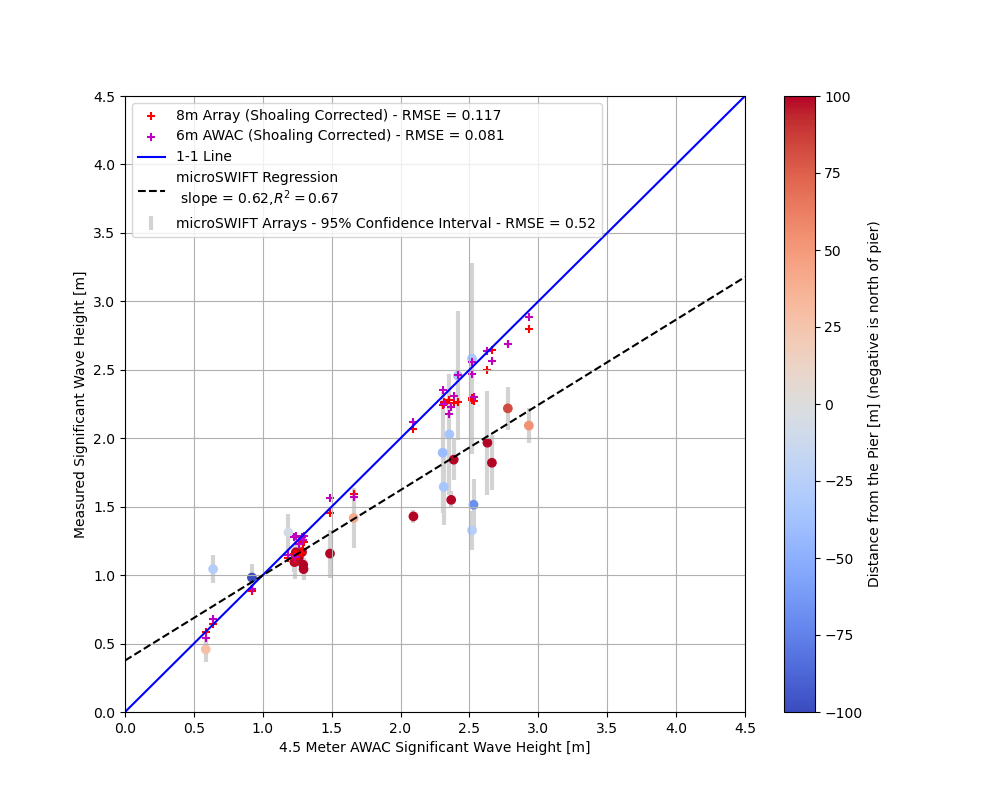

In [19]:
# Compute linear regression between the microSWIFT arrays and the AWAC
slope_45, \
intercept_45, \
r_value_45, \
p_value_45, \
std_err_45 = stats.linregress(awac_sig_wave_heights_45, 
                              microSWIFT_sig_wave_heights_45)
print(p_value_45)
x_45 = np.linspace(0, 4.5)
y_45 = slope_45 * x + intercept_45

fig, ax = plt.subplots(figsize=(10,8))
ax.errorbar(awac_sig_wave_heights_45, hs_wave_height_for_mission, yerr=ci_for_mission, fmt='none', marker=None,
            ecolor='lightgray', elinewidth=3, capsize=0,
            label=f'microSWIFT Arrays - 95% Confidence Interval - RMSE = {np.round(rmse_microswifts, 3)}',
            zorder=0)
im = ax.scatter(awac_sig_wave_heights_45, hs_wave_height_for_mission, c=alongshore_dist_to_pier, cmap='coolwarm',
                vmin=-100, vmax=100)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Distance from the Pier [m] (negative is north of pier)')
ax.scatter(awac_sig_wave_heights_45, array_8m_sig_wave_heights_45_shoaled, color='r', marker='+', label=f'8m Array (Shoaling Corrected) - RMSE = {np.round(rmse_8marray_shoaled, 3)}')
ax.scatter(awac_sig_wave_heights_45, awac_6m_sig_wave_heights_45_shoaled, color='m', marker='+', label=f'6m AWAC (Shoaling Corrected) - RMSE = {np.round(rmse_6mawac_shoaled, 3)}')
ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x_45, y_45, color='k', linestyle='dashed', 
        label='microSWIFT Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope_45, r_value_45**2))
ax.set_ylabel('Measured Significant Wave Height [m]')
ax.set_xlabel('4.5 Meter AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)

In [20]:
# Adjust wave direction to be relative to shore normal 
array_8m_dir_45_shore_norm = np.array(array_8m_dir_45) - 71.8
print(array_8m_dir_45_shore_norm)
# NOTE: negative is from the north and positive is from the south

# Determine if the microSWIFT missions are in the shadow of the pier
in_pier_shadow = []
for n in range(alongshore_dist_to_pier.size):
    if np.abs(alongshore_dist_to_pier[n]) < 200:
        if np.abs(array_8m_dir_45_shore_norm[n]) > 5:
            in_pier_shadow.append(np.sign(alongshore_dist_to_pier[n] * array_8m_dir_45_shore_norm[n]))
        else:
            in_pier_shadow.append(1)
    else:
        in_pier_shadow.append(1)

in_pier_shadow = np.array(in_pier_shadow, dtype=int)
print(in_pier_shadow)

[  8.92818326 -13.10508667  -4.11013573  -4.86317578   3.7678363
   9.21275501 -14.83113032  10.32636836  -3.89762065  -4.0133223
   0.8530535   -9.04479805   8.67784012 -13.61819304   8.81817076
  -2.06556061  -4.47831547   9.30078033   7.26935437 -14.76359349
  -2.5412533   12.70842083  -5.17543295 -36.69620151   0.78682307
   8.56730494 -15.29848952]
[-1 -1  1  1  1 -1  1 -1  1  1  1 -1 -1  1 -1  1  1 -1 -1  1  1  1 -1  1
  1 -1  1]


1.5401034714970416e-07


(0.0, 4.5)

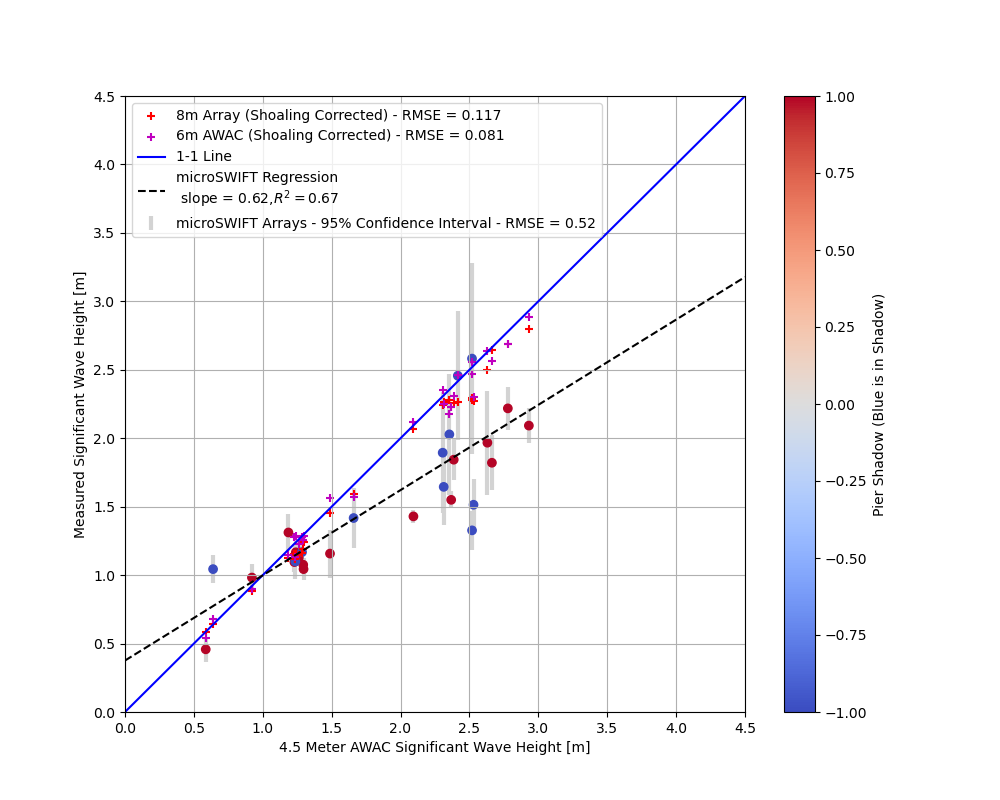

In [21]:
# Compute linear regression between the microSWIFT arrays and the AWAC
slope_45, \
intercept_45, \
r_value_45, \
p_value_45, \
std_err_45 = stats.linregress(awac_sig_wave_heights_45, 
                              microSWIFT_sig_wave_heights_45)
print(p_value_45)
x_45 = np.linspace(0, 4.5)
y_45 = slope_45 * x + intercept_45

fig, ax = plt.subplots(figsize=(10,8))
ax.errorbar(awac_sig_wave_heights_45, hs_wave_height_for_mission, yerr=ci_for_mission, fmt='none', marker=None,
            ecolor='lightgray', elinewidth=3, capsize=0,
            label=f'microSWIFT Arrays - 95% Confidence Interval - RMSE = {np.round(rmse_microswifts, 3)}',
            zorder=0)
im = ax.scatter(awac_sig_wave_heights_45, hs_wave_height_for_mission, c=in_pier_shadow, cmap='coolwarm',
                vmin=-1, vmax=1)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Pier Shadow (Blue is in Shadow)')
ax.scatter(awac_sig_wave_heights_45, array_8m_sig_wave_heights_45_shoaled, color='r', marker='+', label=f'8m Array (Shoaling Corrected) - RMSE = {np.round(rmse_8marray_shoaled, 3)}')
ax.scatter(awac_sig_wave_heights_45, awac_6m_sig_wave_heights_45_shoaled, color='m', marker='+', label=f'6m AWAC (Shoaling Corrected) - RMSE = {np.round(rmse_6mawac_shoaled, 3)}')
ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x_45, y_45, color='k', linestyle='dashed', 
        label='microSWIFT Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope_45, r_value_45**2))
ax.set_ylabel('Measured Significant Wave Height [m]')
ax.set_xlabel('4.5 Meter AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)